# Comments
1. Nice narrative and solid results.
1. Thanks for creating sections for the questions so that it's easier for me to navigate.

In [1]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
#import random
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
ctl.__version__

'1.0.7'

### 1. Choosing ODE Model

In [2]:
'''#Messiha2013 - Pentose phosphate pathway model
pp = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000502.2?filename=BIOMD0000000502_url.xml")
pp.simulate()
pp.plot()'''

'''#Ray2013 - Meiotic initiation in S. cerevisiae
mm = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000626.2?filename=BIOMD0000000626_url.xml")
mm.simulate()
mm.plot()'''

'#Ray2013 - Meiotic initiation in S. cerevisiae\nmm = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000626.2?filename=BIOMD0000000626_url.xml")\nmm.simulate()\nmm.plot()'

#### Load model with tellurium

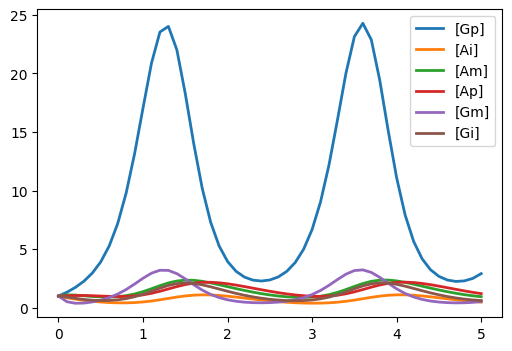

In [3]:
#Garde2020 - metabolic oscillations in Bacillus subtilis biofilms
#paper link: https://www.nature.com/articles/s41598-020-62526-6
GARDE_MODEL = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001053.2?filename=Garde2020.xml")
GARDE_MODEL.simulate()
GARDE_MODEL.plot()

#### Determine parameters
Control input u(t) = Gm
<br /> Output y(t) = Gi
<br /> Control objective = want setpoint to be 1.5 and reduce oscillations

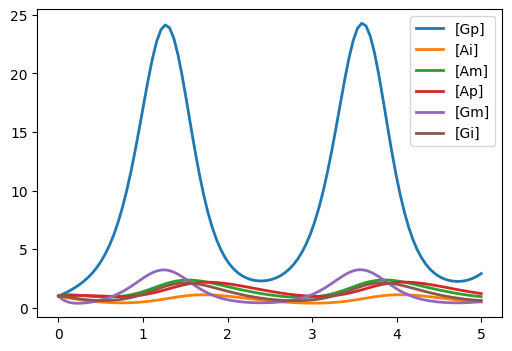

In [4]:
GARDE_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001053.2?filename=Garde2020.xml", 
                        input_names=["Gm"], output_names=["Gi"])
GARDE_RR = GARDE_CTLSB.roadrunner
GARDE_RR.simulate(0, 5, 100)
GARDE_RR.plot()

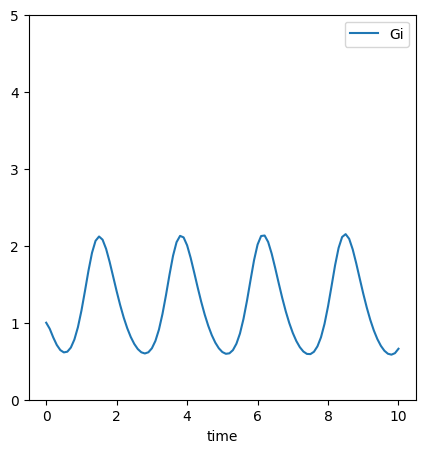

In [5]:
# Simulate the open loop system with no change in its input (Gm)
garde_sys = GARDE_CTLSB.makeNonlinearIOSystem("garde_sys") #command to create the nonlinear IO system for this model
ts = ctl.simulateSystem(garde_sys, end_time=10) #ts = time series object
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 5])

### 2. Constructing CLS 1

#### Helpers

In [6]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

In [7]:
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

OK!


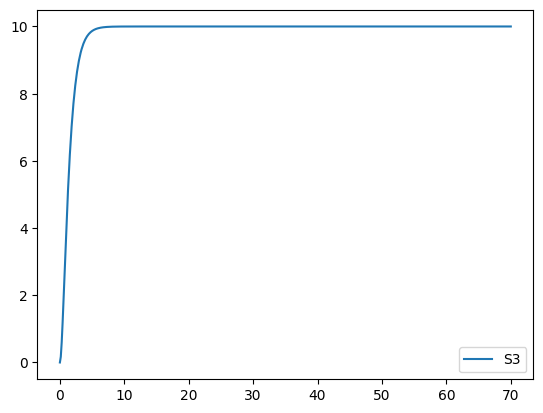

In [8]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(0, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
times = T = np.linspace(0, 70, 500)
times, predictions, _ = plotSys(TEST_SYS, times, is_plot=True)
assert(len(times) == len(predictions[0]))
print("OK!")

#### (Pure) PI controller

In [9]:
#defining a global variable for set point
Gi_SETPOINT = 1.5

OK


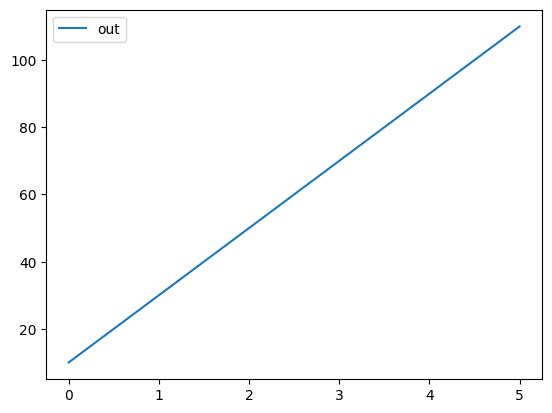

In [10]:
def makePurePIController(kP=20, kI=10):
    """
    Makes a PI controller with control error as input
    
    Parameters
    ----------
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (control error)
        # returns: array-float (derivative of state)
        return u[0]

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state) #integral of control error
        # u: array-float (inputs) #u = control error
        # returns: array (output)
        output = kI*x[0] + kP*u[0]
        return output

    #nonlinear IO system constructor
    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
kP = 10
kI = 20
controller_sys = makePurePIController(kP=kP, kI=kI)
assert("NonlinearIOSystem" in str(type(controller_sys)))
times, data,_ = plotSys(controller_sys, forced_input=[1], is_plot=True)
assert(data[0] == kP)
assert(np.isclose(data[-1], kP + times[-1]*kI))
print("OK")

#### Adder

OK


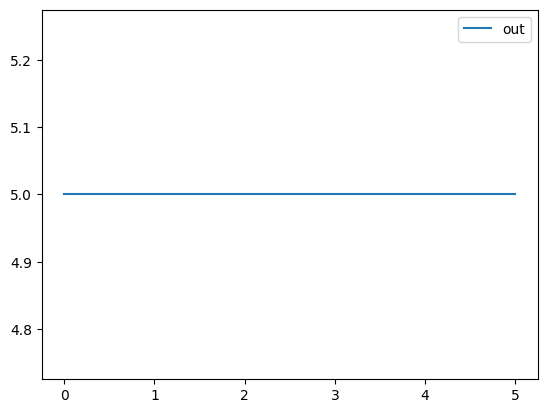

In [11]:
def makeAdder(input_names, output_name="out", system_name="adder_sys"):
    """
    Creates a NonlinearIOSystem that does addition
    of the inputs. Any name that begins wit a "-" is subtracted.
    
    Parameters
    ----------
    input_nmames: list-str
    output_name: str
    system_name: str
    
    Returns
    -------
    NonlinearIOSystem
    """
    adjustments = []
    adjusted_input_names = []
    def outfcn(_, __, u, ___):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return adjustments.dot(u)
    #
    for name in input_names:
        if name[0] == "-":
            value = -1
            new_name = name[1:]
        else:
            value = 1
            new_name = name
        adjustments.append(value)
        adjusted_input_names.append(new_name)
    adjustments = np.array(adjustments)
    #
    return control.NonlinearIOSystem(
          None,
          outfcn,
          inputs=adjusted_input_names,
          outputs=output_name, name=system_name)

# Tests
adder_sys = makeAdder(["a", "-b", "c"])
assert("NonlinearIOSystem" in str(type(adder_sys)))
# Simulate to verify 
_, data, __ = plotSys(adder_sys, forced_input=[3, 2, 4], is_plot=True)
assert(np.var(data[0]) == 0)
assert(data[0][0] == 5)
print("OK")

#### Interconnect parts: Adder, controller, OLS

OK!


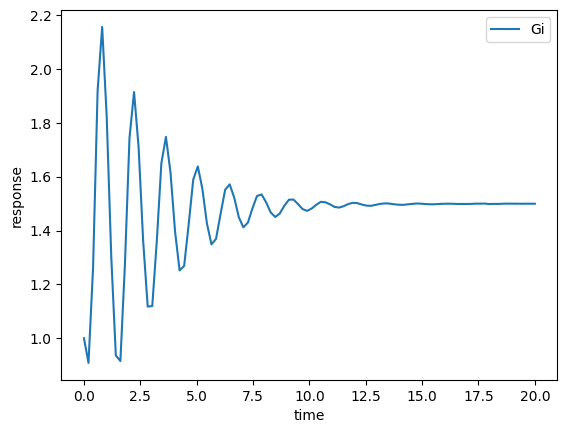

In [12]:
def makeInterconnectWithDiffer(garde_sys=garde_sys, **kwargs):
    """
    Create an Interconnect object for the Wolf closed loop system.
    
    Parameters
    ----------
    wolf_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePurePIController(**kwargs)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    closed_sys = control.interconnect(
      [garde_sys, controller_sys, differ_sys],       # systems
      connections=[
        ['differ_sys.measurement', "garde_sys.Gi"], 
        ['garde_sys.Gm', 'controller_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["garde_sys.Gi"],
    )
    return closed_sys

# Tests
setpoint = 1.5
new_closed_sys = makeInterconnectWithDiffer(kP=50, kI=50)
assert("Interconnect" in str(type(new_closed_sys)))
_, data, ax = plotSys(new_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
ax.set_xlabel("time")
ax.set_ylabel("response")
#assert(data[0] == 5)
assert(np.abs(setpoint - data[-1]) < 0.2)
print("OK!")

#### Optimizing kP and kI to achieve objective
Control objective: want setpoint to be 1.5 and reduce oscillations

Text(0.5, 1.0, 'Comparisons of closed loop designs')

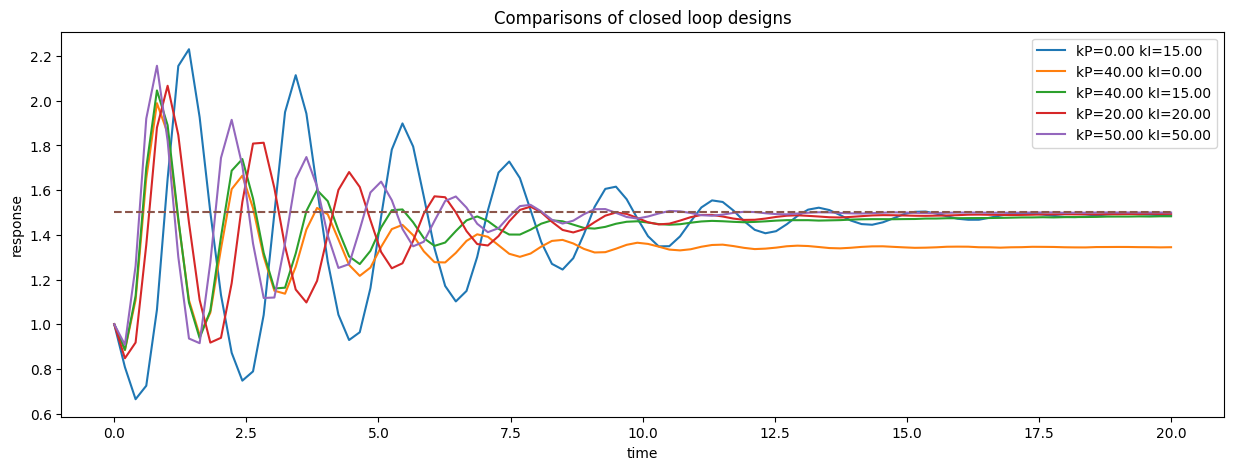

In [13]:
# Compare controller designs, using diff parameter values and compare plots
setpoint = 1.5
pairs = [(0,15), (40,0), (40, 15), (20, 20), (50, 50)] # kP, kI
_, ax = plt.subplots(1, figsize=(15, 5))
times = np.linspace(0, 20, 100) #time unit is in seconds
legends = []
for idx, (kP, kI) in enumerate(pairs):
    title = "kP=%2.2f kI=%2.2f" % (kP, kI)
    legends.append(title)
    new_closed_sys = makeInterconnectWithDiffer(kP=kP, kI=kI)
    _ = plotSys(new_closed_sys, forced_input=[setpoint], times=times,
                      output_labels=["Gi"], ax=ax)
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.legend(legends)
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs")

#### Observations:
* P controller dampened the oscillation but response is far from set point
* Presence of I controller helps reached set point faster
* Larger values of **kP and kI (50,50)** provided the response that satisfies the objective and reached the set point faster compared to **kP and kI (20,20)**

### 3. Constructing CLS 2

#### a. Create a Flakifier non-linear IO system

OK


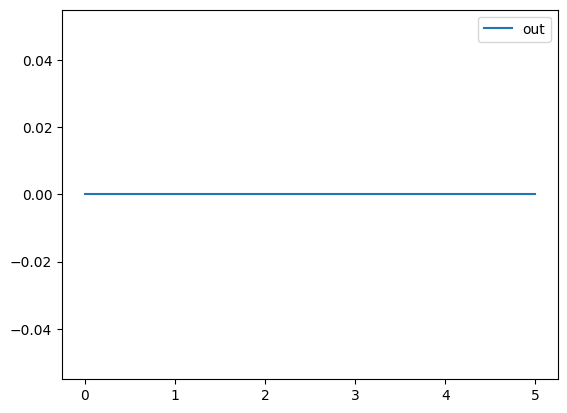

In [14]:
def makeFlakifier(kF, p):
    """
    Makes a Flakifier with controller ouput u(t) as its input 
    Given a probability (p), Flakifier would make the output u'(t) to either u(t) or 0
    
    Parameters
    ----------
    kF = float (Flakifier constant)
    p = float (probability)
   
    Returns
    -------
    NonlinearIOSystem
    """
    
    
    # Calculate derivative of state
    def updfcnFlak(t,x,u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (flakifier input from controller)
        # returns: array-float (output)
        flaky = np.random.rand(1) 
        if flaky[0] <= p:
            dx = kF*u[0] - kF*x[0]
        else:
            dx = 0
        return dx
        

    # Calculate output value
    def outfcnFlak(t,x,u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        return x[0]

    flakifier_sys = control.NonlinearIOSystem(
      updfcnFlak,
      outfcnFlak,
      states=1,
      inputs=['in'],
      outputs=['out'], name='flakifier_sys')
    return flakifier_sys

# Tests
p = 0.8
kF = 1
flakifier_sys = makeFlakifier(kF, p)
assert("NonlinearIOSystem" in str(type(flakifier_sys)))
times, data,_ = plotSys(flakifier_sys, is_plot=True)
print("OK")

#### b. Testbed, Interconnect parts of CLS2: Adder, controller, flakifier, OLS

OK!


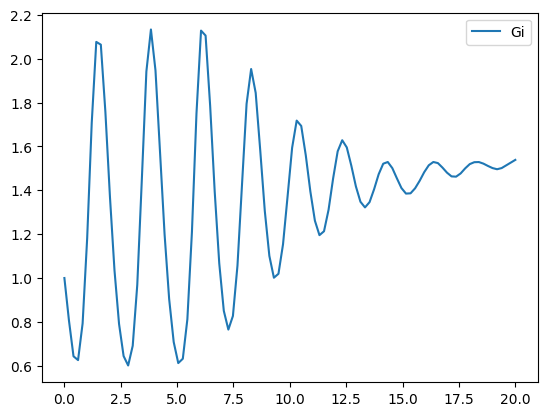

In [15]:
def makeInterconnectWithFlakifier(kP,kI,kF,p, garde_sys=garde_sys, flakifier_sys=flakifier_sys):
    """
    Create an Interconnect object for the Garde closed loop system.
    
    Parameters
    ----------
    garde_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePurePIController(kP,kI)
    differ_sys = makeAdder(["setpoint", "-measurement"], system_name="differ_sys")
    flakifier_sys = makeFlakifier(kF,p)
    nu_closed_sys = control.interconnect(
      [garde_sys, controller_sys, differ_sys, flakifier_sys],       # systems
      connections=[
        ['differ_sys.measurement', "garde_sys.Gi"], 
        ['garde_sys.Gm', 'flakifier_sys.out'],
        ['controller_sys.in',  'differ_sys.out'],
        ['flakifier_sys.in', 'controller_sys.out']
      ],
      inplist=["differ_sys.setpoint"],
      outlist=["garde_sys.Gi"],
    )
    return nu_closed_sys

# Tests
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(20, 10, 1, 0.2)
assert("Interconnect" in str(type(nu_closed_sys)))
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
print("OK!")

#### c. Tune controller when p= 0.8

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.8')

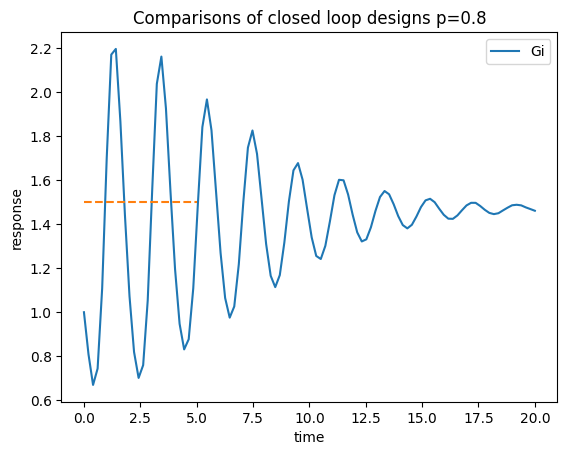

In [16]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(20, 10, 1, 0.8) #starting value
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.8")

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.8')

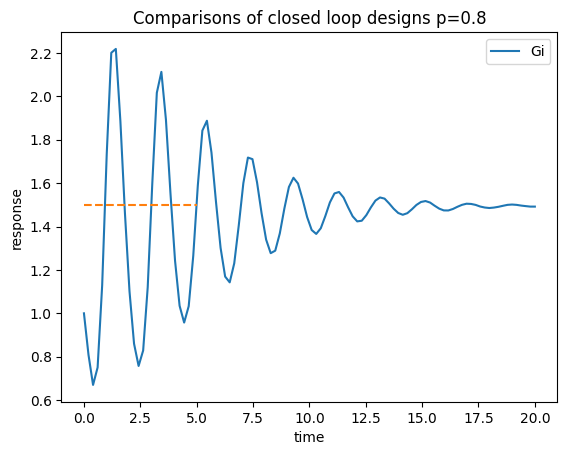

In [17]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(20, 20, 1, 0.8) #Increase kI
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.8")

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.8')

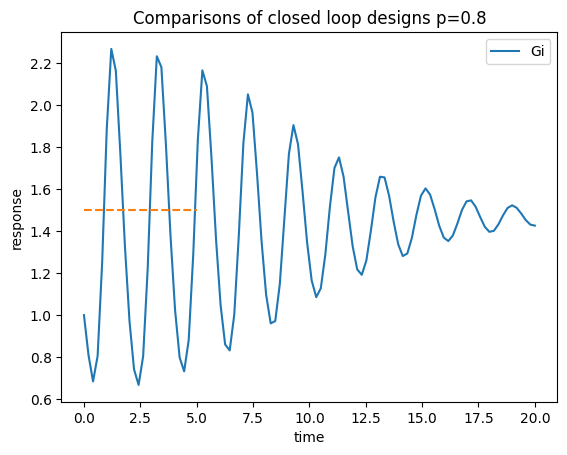

In [18]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(30, 10, 1, 0.8) #Increase kP
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.8")

#### d. Tune controller when p=0.2

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.2')

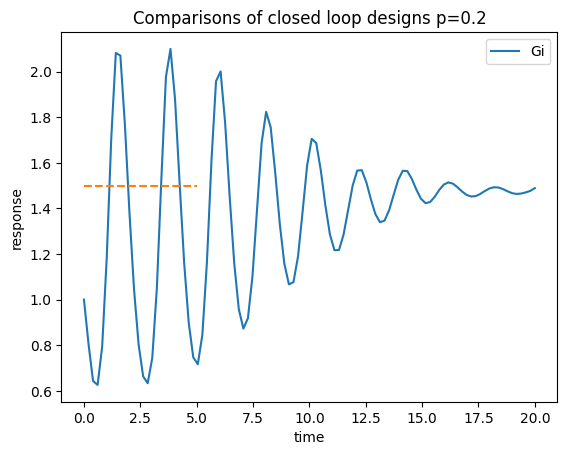

In [19]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(20, 10, 1, 0.2)
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.2")

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.2')

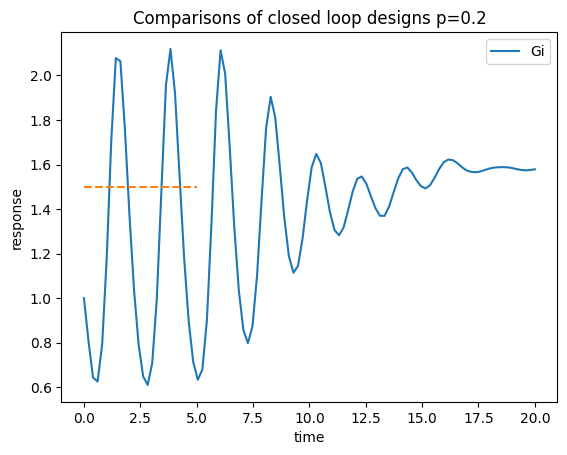

In [20]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(20, 20, 1, 0.2) #Increase kI
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.2")

Text(0.5, 1.0, 'Comparisons of closed loop designs p=0.2')

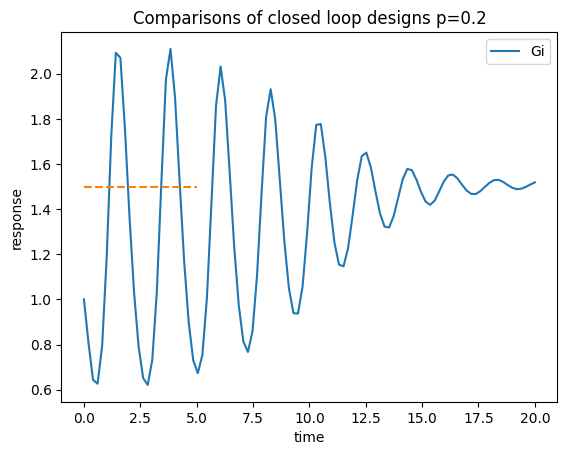

In [21]:
setpoint = 1.5
nu_closed_sys = makeInterconnectWithFlakifier(30, 10, 1, 0.2) #Increase kP
_, data, ax = plotSys(nu_closed_sys, forced_input=[setpoint], times=np.linspace(0, 20, 100), is_plot=True,
                      output_labels=["Gi"])
plt.plot([times[0], times[-1]], [setpoint, setpoint], linestyle="--")
plt.xlabel("time")
plt.ylabel("response")
plt.title("Comparisons of closed loop designs p=0.2")

### 4. Summarize the challenges your encountered with tuning CLS 1, CLS 2 with p=0.8, and CLS 2 with p= 0.2.

Tuning CLS1 was not as bad as tuning CLS2. For CLS1, oscillation was dampened pretty easily after trying several values of kP and kI. P controller dampened the oscillation but response is far from set point. The presence of I controller helps reached set point faster.

<br/> For CLS2, Flakifier keeps giving me a straight line at zero as my Flakifier output regardless of the probability (p) and Flakifier constant (kF) values I put in, but I proceded anyway to interconnect all parts and observed the results after tuning the controller.

* for p=0.8
<br/> Increasing kP resulted in increased oscillation and longer time to reach setpoint. kI did a pretty good job of dampening oscillation and reaching setpoint quicker.

* for p=0.2
<br/> Increasing kI caused "biased' (overshoot) above setpoint. Increasing kP helped reaching setpoint faster.
